In [2]:
import ast
import cv2
import random
import numpy as np
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader
import os

In [3]:
%cd G:\My Drive\object_detection

G:\My Drive\object_detection


In [4]:
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 1280
BATCH_SIZE = 16
CROP_SCALE_HEIGHT_BDD100K = 0.8
CROP_SCALE_WIDTH_BDD100K = 0.8
BBOX_PARAMS = {
    "format": "pascal_voc",
    "min_visibility": 0.3,
    "label_fields": ['category_ids']
}

CLASS_MAP_KITTI_BDD100K = {
    'Car': 0,
    'Pedestrian': 1,
    'Van': 2,
    'Cyclist': 3,
    'Truck': 4,
    'Tram': 5,
    'Person_sitting': 6,
    "Rider": 7, 
    "Bus": 8,
    "Train": 9,
    "Motorcycle": 10,
    "Bicycle": 11,
    "Traffic-sign": 12,
    "Traffic-light": 13
}

In [12]:
# read from file
file_path = os.path.join("../Master_Thesis_MMDE/outputs", "mean_std_bdd100k.txt")

with open(file_path, mode="r") as f:
    lines = f.readlines()

mean_line = lines[0].split()[1:]
std_line = lines[1].split()[1:]

MEAN = ast.literal_eval(" ".join(mean_line))
STD = ast.literal_eval(" ".join(std_line))

print("Mean:", MEAN)
print("Std:", STD)

Mean: [0.2784, 0.2928, 0.2904]
Std: [0.247, 0.2652, 0.2762]


In [13]:
def create_train_val_split_bdd100k(tx_dir, ty_dir, vx_dir, vy_dir):
    
    train_x = sorted(glob(os.path.join(tx_dir, "*")))
    train_y = sorted(glob(os.path.join(ty_dir, "*")))
    
    val_x = sorted(glob(os.path.join(vx_dir, "*")))
    val_y = sorted(glob(os.path.join(vy_dir, "*")))
    
    assert len(train_x) == len(train_y)
    assert len(val_x) == len(val_y)
    
    return (train_x, train_y), (val_x, val_y)

images_train_dir = "bdd100k/images/100k/train"
images_val_dir = "bdd100k/images/100k/val"

labels_train_dir = "data/bdd100k/labels/100k/train"
labels_val_dir = "data/bdd100k/labels/100k/val"

(train_x, train_y), (val_x, val_y) = create_train_val_split_bdd100k(
    images_train_dir, labels_train_dir, images_val_dir, labels_val_dir
)

print(f"Train length = x: {len(train_x)} | y: {len(train_y)}")
print(f"Val Length = x: {len(val_x)} | y: {len(val_y)}")

Train length = x: 30549 | y: 30549
Val Length = x: 10000 | y: 10000


In [14]:
train_transform_bdd100k = A.Compose(
    [
        A.OneOf(
            [
                A.RandomCrop(
                    width=int(IMAGE_WIDTH * CROP_SCALE_WIDTH_BDD100K),
                    height=int(IMAGE_HEIGHT * CROP_SCALE_HEIGHT_BDD100K),
                p=0.5),
                A.CenterCrop(
                    width=IMAGE_WIDTH,
                    height=IMAGE_HEIGHT,
                p=0.5)
            ],
            p=1.0,
        ),
        A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Equalize(p=0.05),
        A.RandomToneCurve(p=0.05),
        A.Sharpen(p=0.05),
        A.CLAHE(p=0.05),
        A.Posterize(p=0.05),
        A.Blur(p=0.01),
        A.MedianBlur(p=0.01)
    ],
    bbox_params=A.BboxParams(**BBOX_PARAMS),
)

val_transform_bdd100k = A.Compose(
    [
        A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0),
    ],
    bbox_params=A.BboxParams(**BBOX_PARAMS),
)

In [15]:
class BDD100KDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets,
        transform,
        class_map,
        image_height,
        image_width,
        mean=[0., 0., 0.],
        std=[1., 1., 1.]
    ):
        
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.class_map = class_map
        self.image_height = image_height
        self.image_width = image_width

        self.final_transform = A.Compose([
                A.Normalize(mean=mean, std=std, max_pixel_value=255),
                ToTensorV2(),
        ])
    
    def read_image(self, path):
        return cv2.cvtColor(
            cv2.imread(path, cv2.IMREAD_COLOR), 
            cv2.COLOR_BGR2RGB
        )
    
    def read_label(self, path):
        with open(path, 'r') as f:
            labels = f.read().splitlines()
        return labels
    
    def get_class_ids_and_bboxes(self, labels):
        # Convert the list to a NumPy array
        arr = np.array([line.split() for line in labels])

        # Extract class indices using class_map
        class_ids = np.array([self.class_map[class_name] for class_name in arr[:, 0]], dtype=int)

        # Extract xyxy coordinates
        bboxes = arr[:, 2:6].astype(float)
                                 
        return class_ids.tolist(), bboxes.tolist()
    
    def pascal_voc_to_yolo(self, bboxes):
        
        for i in range(len(bboxes)):
            xmin, ymin, xmax, ymax = bboxes[i]

            # Calculate center coordinates
            x_center = (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2

            # Calculate width and height
            width = xmax - xmin
            height = ymax - ymin

            # Normalize coordinates and dimensions
            x_center /= self.image_width
            y_center /= self.image_height
            width /= self.image_width
            height /= self.image_height

            bboxes[i] = [x_center, y_center, width, height]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        # Load image and label
        image = self.read_image(self.inputs[idx])
        labels = self.read_label(self.targets[idx])

        if not labels:
            # if file is empty, get random image and labels
            random_idx = np.random.randint(0, len(self.inputs))
            return self.__getitem__(random_idx)
        
        # get class_ids and bboxes
        class_ids, bboxes = self.get_class_ids_and_bboxes(labels)

        if not bboxes:
            # if image has 0 bboxes, get random image and labels
            random_idx = np.random.randint(0, len(self.inputs))
            return self.__getitem__(random_idx)

        # preprocess
        aug = self.transform(image=image, bboxes=bboxes, category_ids=class_ids)
        image = aug["image"]
        bboxes = aug["bboxes"]
        class_ids = aug["category_ids"]
        
        if not bboxes:
            # after preprocess; if image has 0 bboxes, get random image and labels
            random_idx = np.random.randint(0, len(self.inputs))
            return self.__getitem__(random_idx)
        
        # final transform
        image = self.final_transform(image=image)["image"]

        # convert pascal_voc bboxes (xyxy) to yolo bboxes (xn,yn,wn,hn : normalized)
        self.pascal_voc_to_yolo(bboxes)
        
        # Combine class indices and bboxes coordinates
        target = torch.column_stack([
            torch.tensor(class_ids, dtype=torch.float32),
            torch.tensor(bboxes, dtype=torch.float32)
        ]) # shape: (num_bboxes, 5); [class_index, xn, yn, wn, hn]

        return image, target


In [16]:
# create train and val datasets
train_dataset_bdd100k = BDD100KDataset(
    inputs=train_x,
    targets=train_y,
    transform=train_transform_bdd100k,
    class_map=CLASS_MAP_KITTI_BDD100K,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    mean=MEAN,
    std=STD
)

val_dataset_bdd100k = BDD100KDataset(
    inputs=val_x,
    targets=val_y,
    transform=val_transform_bdd100k,
    class_map=CLASS_MAP_KITTI_BDD100K,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    mean=MEAN,
    std=STD
)

In [17]:
def collate_fn(batch):
    """
    Collates data samples into batches.
    
    Note:
    Output dimension (along 0th axis) of `stacked_images`
    may or may not be equal to the `concatenated_targets`.
    
    """
    images, targets = zip(*batch)

    # Stack images along the new dimension 0; shape = (B, C, H, W)
    stacked_images = torch.stack(images, dim=0)
    
    # Concatenate the tensors along newly created dimension 0
    # which represents the batch index; shape = (Num_batch_Boxes, 6)
    # [batch_id, class_index, xn, yn, wn, hn]
    concatenated_targets = torch.cat([
        torch.cat([idx * torch.ones(target.size(0), 1), target], dim=1)
        for idx, target in enumerate(targets)
    ], dim=0)

    return stacked_images, concatenated_targets

In [ ]:
train_data = DataLoader(
    train_dataset_bdd100k,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

val_data = DataLoader(
    val_dataset_bdd100k,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

In [19]:
image,target = next(iter(train_data))

In [20]:
image.shape

torch.Size([16, 3, 320, 1280])

In [21]:
target

tensor([[0.0000e+00, 1.2000e+01, 5.4208e-01, 4.3485e-01, 1.2292e-02, 5.4631e-02],
        [0.0000e+00, 1.2000e+01, 4.9051e-01, 3.2832e-01, 3.4250e-02, 8.1947e-02],
        [0.0000e+00, 1.2000e+01, 5.2812e-01, 3.2559e-01, 3.2779e-02, 8.7410e-02],
        [0.0000e+00, 0.0000e+00, 5.1311e-01, 4.9866e-01, 2.3218e-02, 7.9666e-02],
        [0.0000e+00, 0.0000e+00, 4.8808e-01, 4.9477e-01, 1.8176e-02, 5.7385e-02],
        [0.0000e+00, 0.0000e+00, 4.5522e-01, 4.8128e-01, 1.5024e-02, 3.8242e-02],
        [1.0000e+00, 1.2000e+01, 4.3344e-01, 4.4863e-01, 1.8180e-02, 2.7970e-02],
        [1.0000e+00, 1.2000e+01, 4.3903e-01, 4.1227e-01, 9.7894e-03, 5.5939e-02],
        [1.0000e+00, 1.2000e+01, 4.9497e-01, 3.8151e-01, 5.4541e-02, 1.0628e-01],
        [1.0000e+00, 1.2000e+01, 5.4252e-01, 3.6193e-01, 2.6571e-02, 1.0069e-01],
        [1.0000e+00, 0.0000e+00, 5.0756e-01, 5.7157e-01, 2.6571e-02, 1.0602e-01],
        [1.0000e+00, 0.0000e+00, 4.1648e-01, 6.1461e-01, 6.0493e-02, 1.8092e-01],
        [1.0000e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1271256..2.9214575].


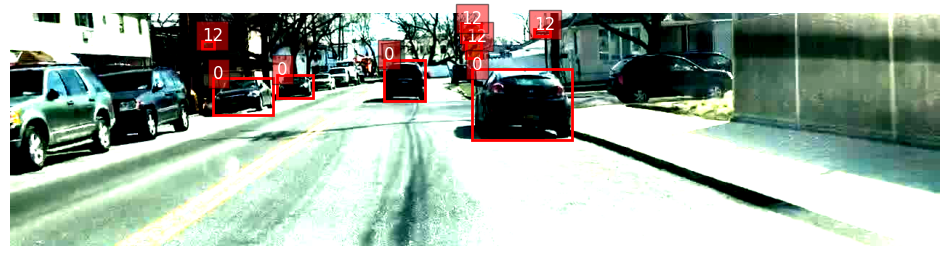

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image_with_collated_bboxes(image, target):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())

    for bbox in target:
        img_idx, class_id, x_center, y_center, width, height = bbox
        x_min = (x_center - width / 2) * IMAGE_WIDTH
        y_min = (y_center - height / 2) * IMAGE_HEIGHT
        rect = patches.Rectangle(
            (x_min, y_min), width * IMAGE_WIDTH, height * IMAGE_HEIGHT,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{int(class_id)}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

visualize_image_with_collated_bboxes(image[8], target[target[:, 0] == 8])

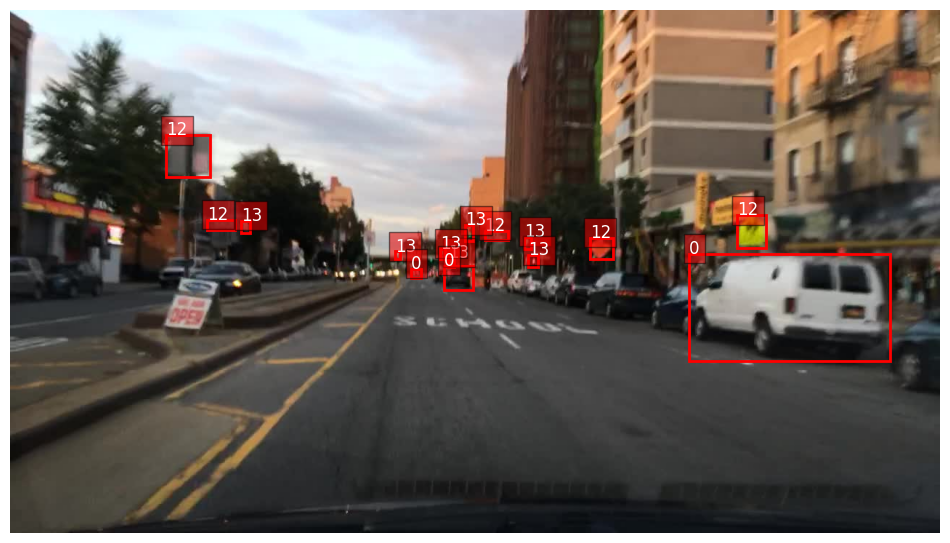

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image_with_bboxes(image, target):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())

    for bbox in target:
        class_id, x_center, y_center, width, height = bbox
        x_min = (x_center - width / 2) * IMAGE_WIDTH
        y_min = (y_center - height / 2) * IMAGE_HEIGHT
        rect = patches.Rectangle(
            (x_min, y_min), width * IMAGE_WIDTH, height * IMAGE_HEIGHT,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{int(class_id)}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

visualize_image_with_bboxes(image, target)

In [28]:
# INFO
num_train_samples = len(train_dataset_bdd100k.dataset)
num_val_samples = len(val_dataset_bdd100k.dataset)

num_train_steps = len(train_dataset_bdd100k)
num_val_steps = len(val_dataset_bdd100k)

print(f"Number of samples: Train: {num_train_samples} | Val: {num_val_samples}")
print(f"Number of steps: Train: {num_train_steps} | Val: {num_val_steps}")

AttributeError: 'BDD100KDataset' object has no attribute 'dataset'